# Compare object detection and panoptic segmentation

Understand when to use bounding boxes versus pixel-level masks for image analysis.

**What's in this recipe:**

- Run object detection to get bounding boxes and labels
- Run panoptic segmentation to get pixel-level masks
- Visualize and compare outputs side-by-side

## Problem

You need to analyze objects in images, but there are two approaches:

| Approach | Output | Example |
|----------|--------|---------|
| Object Detection | Bounding boxes | "Car at [100, 200, 300, 400]" |
| Panoptic Segmentation | Pixel masks | "These 45,000 pixels are a car" |

Which should you use? Detection is faster but approximate. Segmentation is slower but precise.

## Solution

Run both approaches on the same images using DETR models and compare the results.

### Setup

In [ ]:
%pip install -qU pixeltable torch transformers timm

In [2]:
import numpy as np

import pixeltable as pxt
from pixeltable.functions.huggingface import detr_for_object_detection, detr_for_segmentation
from pixeltable.functions.vision import draw_bounding_boxes, overlay_segmentation

### Load images

In [3]:
pxt.drop_dir('detection_vs_seg', force=True)
pxt.create_dir('detection_vs_seg')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'detection_vs_seg'.


/opt/miniconda3/envs/pixeltable/lib/python3.11/site-packages/pixeltable/env.py:501: UserWarning: Progress reporting is disabled because ipywidgets is not installed. To fix this, run: `pip install ipywidgets`
  warnings.warn(


In [4]:
images = pxt.create_table('detection_vs_seg.images', {'image': pxt.Image})

base_url = 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images'
images.insert([
    {'image': f'{base_url}/000000000034.jpg'},
    {'image': f'{base_url}/000000000049.jpg'},
])

Created table 'images'.
Inserted 2 rows with 0 errors in 0.22 s (9.21 rows/s)


2 rows inserted.

### Run object detection

The `detr_for_object_detection` function returns bounding boxes, labels, and confidence scores.

**Parameters:**

- `model_id`: DETR variant (`facebook/detr-resnet-50` or `facebook/detr-resnet-101`)
- `threshold`: Confidence threshold (0.0-1.0). Higher = fewer but more confident detections

**Output:**

```python
{'boxes': [[x1, y1, x2, y2], ...], 'scores': [0.98, ...], 'label_text': ['person', ...]}
```

In [5]:
images.add_computed_column(
    detections=detr_for_object_detection(
        images.image,
        model_id='facebook/detr-resnet-50',
        threshold=0.8
    )
)

Added 2 column values with 0 errors in 4.09 s (0.49 rows/s)


2 rows updated.

image,detections
,"{""boxes"": [[-0.211, 19.447, 439.428, 400.467]], ""labels"": [24], ""scores"": [1.], ""label_text"": [""zebra""]}"
,"{""boxes"": [[188.769, 331.565, 198.354, 355.864], [185.852, 233.014, 236.063, 333.159], [219.973, 265.153, 268.188, 324.031], [125.314, 259.508, 173.575, 323.718], [80.611, 242.665, 186.57, 402.725], [119.625, 339.19, 130.863, 367.763], [199.302, 428.034, 273.116, 474.461], [281.164, 330.917, 292.259, 360.183], [166.45, 225.1, 292.048, 411.36]], ""labels"": [1, 1, 1, 1, 19, 1, 64, 1, 19], ""scores"": [0.88, 0.945, 0.967, 0.992, 0.999, 0.987, 0.967, 0.978, 0.998], ""label_text"": [""person"", ""person"", ""person"", ""person"", ""horse"", ""person"", ""potted plant"", ""person"", ""horse""]}"

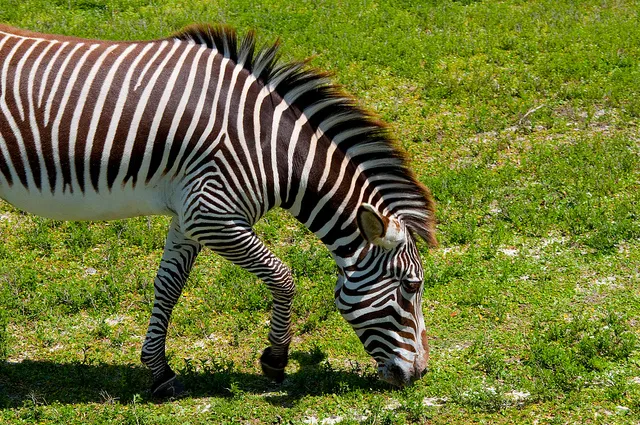
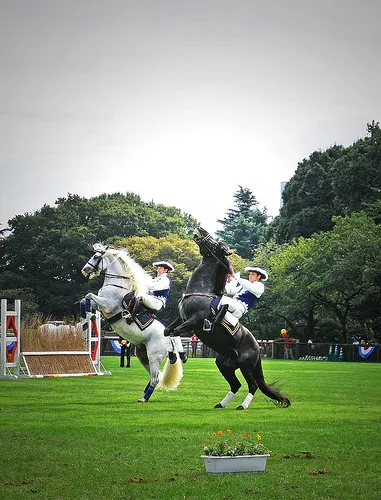

In [6]:
# View detection results
images.select(images.image, images.detections).collect()

### Visualize detections with bounding boxes

Use `draw_bounding_boxes` to overlay the detection results on the original image.

In [7]:
images.add_computed_column(
    detection_viz=draw_bounding_boxes(
        images.image,
        boxes=images.detections.boxes,
        labels=images.detections.label_text,
        fill=True,
        width=2
    )
)

Added 2 column values with 0 errors in 0.03 s (58.89 rows/s)


2 rows updated.

detection_viz
""
""

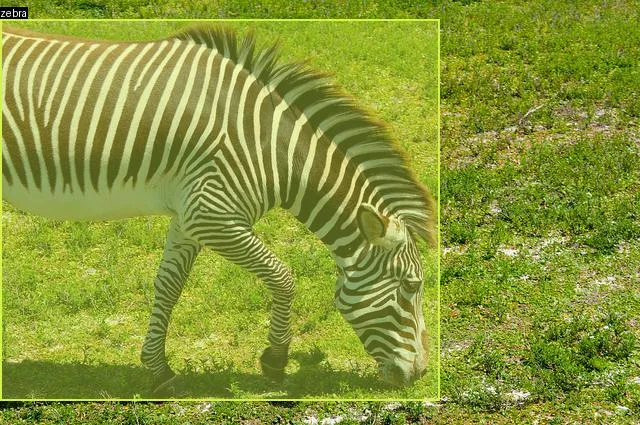
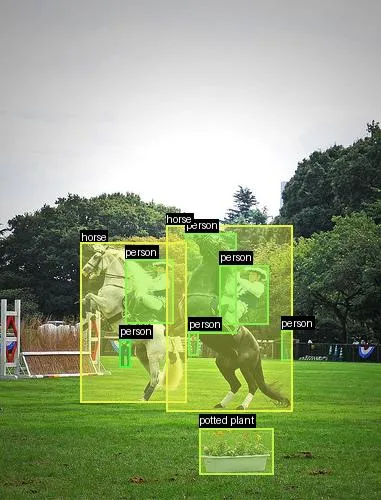

In [8]:
images.select(images.detection_viz).collect()

### Run panoptic segmentation

The `detr_for_segmentation` function returns pixel-level masks and segment metadata.

**Parameters:**

- `model_id`: Segmentation model (`facebook/detr-resnet-50-panoptic`)
- `threshold`: Confidence threshold for filtering segments

**Output:**

```python
{
    'segmentation': np.ndarray,  # (H, W) array where each pixel = segment ID
    'segments_info': [{'id': 1, 'label_text': 'person', 'score': 0.98}, ...]
}
```

> **Note:** The full segmentation output contains a numpy array that can't be stored as JSON. We store just the `segments_info` metadata and compute the pixel-level visualization inline.

In [ ]:
# Store just the segments_info (JSON-serializable) as a computed column
# The segmentation array will be computed inline for visualization
seg_expr = detr_for_segmentation(
    images.image,
    model_id='facebook/detr-resnet-50-panoptic',
    threshold=0.5
)

images.add_computed_column(segments_info=seg_expr.segments_info)

image,segments_info
,"[{""id"": 1, ""score"": 1., ""label_id"": 193, ""was_fused"": false, ""label_text"": ""LABEL_193""}, {""id"": 2, ""score"": 1., ""label_id"": 24, ""was_fused"": false, ""label_text"": ""zebra""}]"
,"[{""id"": 1, ""score"": 0.985, ""label_id"": 1, ""was_fused"": false, ""label_text"": ""person""}, {""id"": 2, ""score"": 0.883, ""label_id"": 185, ""was_fused"": false, ""label_text"": ""LABEL_185""}, {""id"": 3, ""score"": 0.997, ""label_id"": 19, ""was_fused"": false, ""label_text"": ""horse""}, {""id"": 4, ""score"": 1., ""label_id"": 187, ""was_fused"": false, ""label_text"": ""LABEL_187""}, {""id"": 5, ""score"": 0.838, ""label_id"": 1, ""was_fused"": false, ""label_text"": ""person""}, {""id"": 6, ""score"": 0.977, ""label_id"": 1, ""was_fused"": false, ""label_text"": ""person""}, {""id"": 7, ""score"": 0.994, ""label_id"": 64, ""was_fused"": false, ""label_text"": ""potted plant""}, {""id"": 8, ""score"": 0.999, ""label_id"": 184, ""was_fused"": false, ""label_text"": ""LABEL_184""}, {""id"": 9, ""score"": 0.999, ""label_id"": 19, ""was_fused"": false, ""label_text"": ""horse""}, {""id"": 10, ""score"": 0.989, ""label_id"": 1, ""was_fused"": false, ""label_text"": ""person""}, {""id"": 11, ""score"": 0.997, ""label_id"": 193, ""was_fused"": false, ""label_text"": ""LABEL_193""}]"

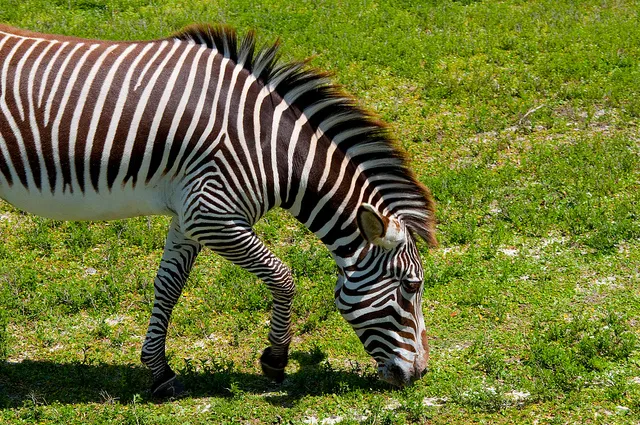
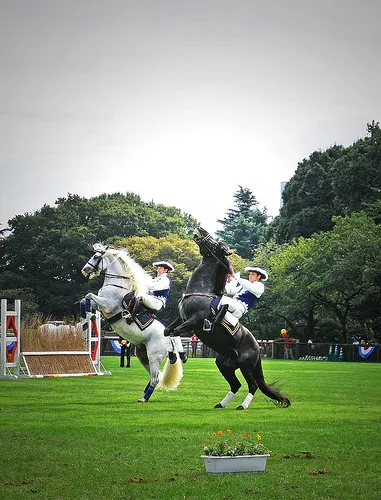

In [ ]:
# View stored segmentation info
images.select(images.image, images.segments_info).collect()


### Visualize segmentation with colored overlay

Use `overlay_segmentation` to visualize the pixel masks with colored regions and contours.

segmentation_viz
""
""

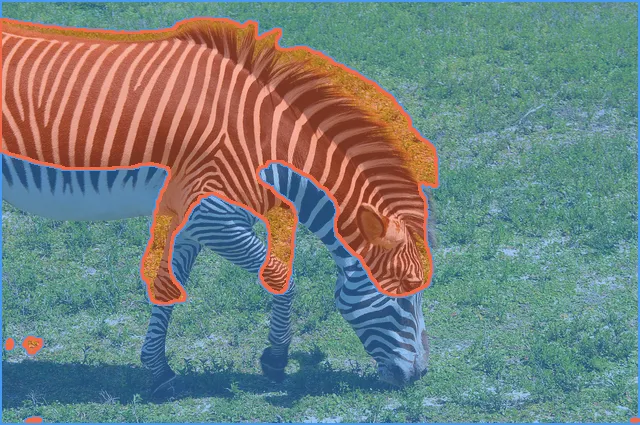
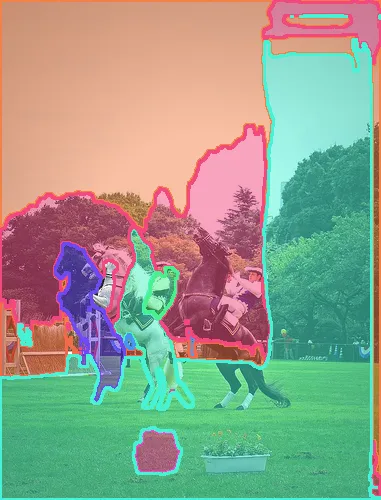

In [11]:
# Compute segmentation visualization inline
# Cast the segmentation array to the proper type for overlay_segmentation
seg_expr = detr_for_segmentation(
    images.image,
    model_id='facebook/detr-resnet-50-panoptic',
    threshold=0.5
)
segmentation_map = seg_expr.segmentation.astype(pxt.Array[(None, None), np.int32])

images.select(
    segmentation_viz=overlay_segmentation(
        images.image,
        segmentation_map,
        alpha=0.5,
        draw_contours=True,
        contour_thickness=2
    )
).collect()

### Compare side-by-side

image,detection_viz,segmentation_viz
,,
,,

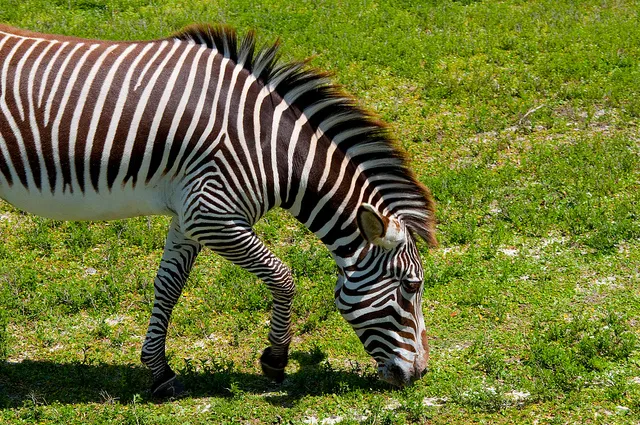
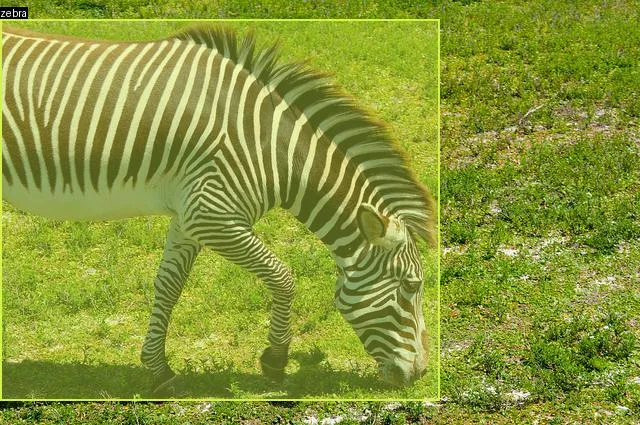
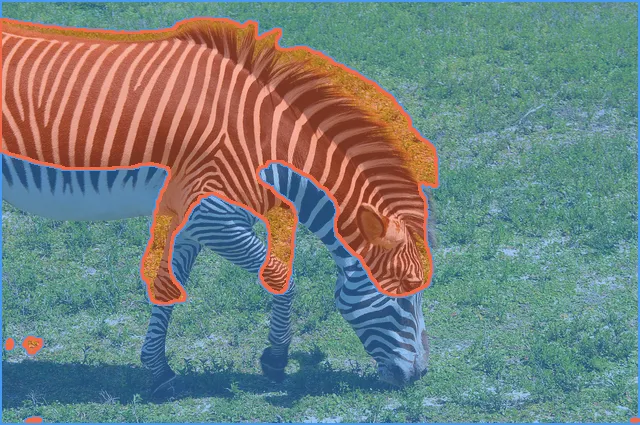
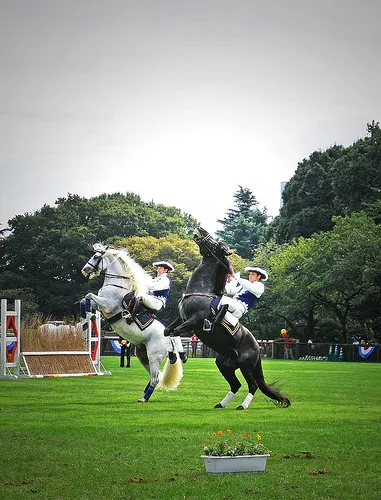
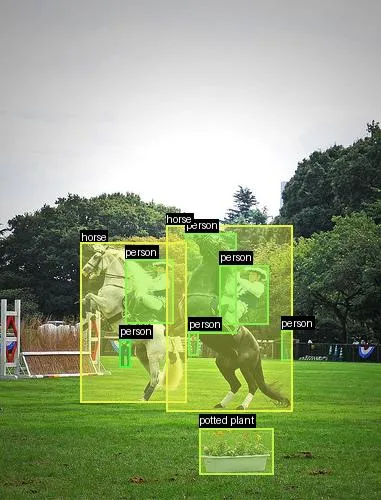
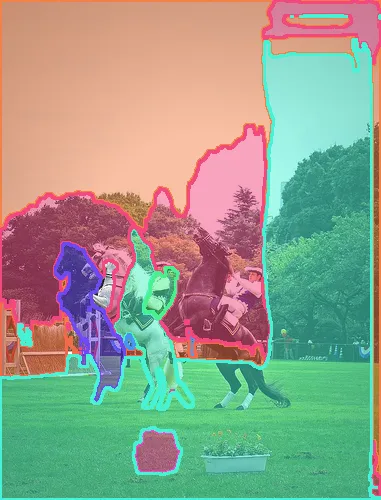

In [12]:
# Side-by-side comparison: original, detection, segmentation
seg_expr = detr_for_segmentation(
    images.image,
    model_id='facebook/detr-resnet-50-panoptic',
    threshold=0.5
)
segmentation_map = seg_expr.segmentation.astype(pxt.Array[(None, None), np.int32])

images.select(
    images.image,
    images.detection_viz,
    segmentation_viz=overlay_segmentation(
        images.image,
        segmentation_map,
        alpha=0.5,
        draw_contours=True,
        contour_thickness=2
    )
).collect()

### Count objects per image

image,num_detections,num_segments
,1,2
,9,11

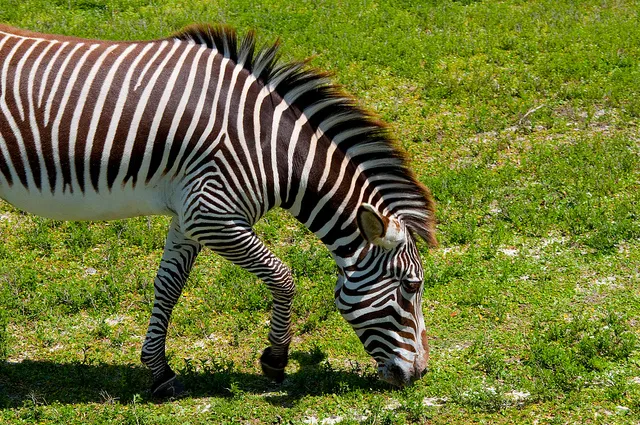
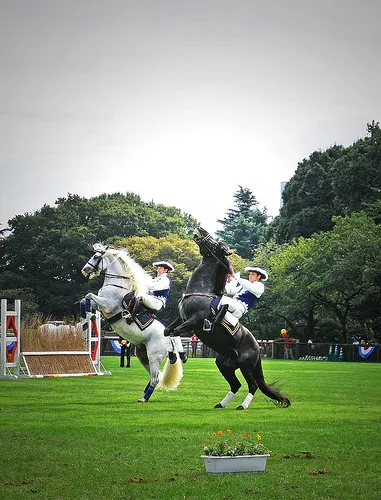

In [13]:
# Count objects per image (using stored columns)
images.select(
    images.image,
    num_detections=images.detections.boxes.apply(len, col_type=pxt.Int),
    num_segments=images.segments_info.apply(len, col_type=pxt.Int)
).collect()


## Explanation

Detection gives fast, approximate locations. Segmentation gives slower but precise boundaries.

### Capability comparison

| Use Case | Detection | Segmentation |
|----------|-----------|--------------|
| Object counting | Yes | Yes |
| Object localization | Yes | Yes |
| Precise boundaries | No | Yes |
| Background removal | No | Yes |
| Scene composition | No | Yes |
| Speed priority | Yes | No |

### Performance tradeoffs

| Metric | Detection | Segmentation |
|--------|-----------|--------------|
| Inference time | ~100ms | ~200ms |
| Output size | ~1KB | ~1MB+ |

### When to use each

**Choose detection when:**

- You need to know *what* objects are present and *where* (approximately)
- Speed matters (detection is 2x faster)
- You need search, filtering, or counting
- Bounding boxes suffice for visualization

**Choose segmentation when:**

- You need *exact* object boundaries (pixel-perfect masks)
- You're doing image editing, compositing, or AR
- You need to measure actual object area/coverage
- You want scene composition analysis (what % is sky vs buildings)

## See also

- [Detect objects in images](./img-detect-objects) - Object detection with YOLOX
- [Visualize detections](./img-visualize-detections) - Draw bounding boxes and labels
- [DETR documentation](https://huggingface.co/docs/transformers/model_doc/detr) - Hugging Face model docs